In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

plt.rcParams['figure.figsize'] = 8, 7
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.family"] = "normal"
plt.rcParams["font.size"] = 25
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
plt.rcParams['axes.labelsize']=18
plt.rcParams['legend.fontsize']: 16
    
sns.set()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
### Setting Up DB Connection ###
db = 'database.sqlite'
conn = sqlite3.connect(db)

### Extracting All Available Tables From DB ###
db_tables = pd.read_sql("""SELECT * 
                            FROM sqlite_master
                            WHERE type='table';""", conn)
print(db_tables)

    type               name           tbl_name  rootpage                                                sql
0  table    sqlite_sequence    sqlite_sequence         4             CREATE TABLE sqlite_sequence(name,seq)
1  table  Player_Attributes  Player_Attributes        11  CREATE TABLE "Player_Attributes" (\n\t`id`\tIN...
2  table             Player             Player        14  CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3  table              Match              Match        18  CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4  table             League             League        24  CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5  table            Country            Country        26  CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6  table               Team               Team        29  CREATE TABLE "Team" (\n\t`id`\tINTEGER PRIMARY...
7  table    Team_Attributes    Team_Attributes         2  CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


 **^^ Here we see we have 7 tables in total we'll be interested in exploring further (Player_Attributes, Player, Match, League, Country, Team, Team_Attributes)**

In [3]:
### Exploring Features in Each Table ###
for table in db_tables.tbl_name:
    if table != 'sqlite_sequence':
        print('\n', table + ': ')
        new = pd.read_sql("""SELECT * 
                            FROM """ + table + """ LIMIT 2""", conn)
        print(new.columns)
                        


 Player_Attributes: 
Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'], dtype='object')

 Player: 
Index(['id', 'player_api_id', 'player_name', 'player_fifa_api_id', 'birthday', 'height', 'weight'], dtype='object')

 Match: 
Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal',
       ...
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD'

# Countries/Leagues/Teams

In [4]:
# Countries in DB #
countries = pd.read_sql("""SELECT DISTINCT name AS Country
                            FROM Country""", conn)
print(countries)

        Country
0       Belgium
1       England
2        France
3       Germany
4         Italy
5   Netherlands
6        Poland
7      Portugal
8      Scotland
9         Spain
10  Switzerland


In [5]:
# Leagues in each country # 
league_country = pd.read_sql("""SELECT c.name AS Country, l.name AS League
                            FROM League AS l
                            INNER JOIN Country AS c
                            ON l.country_id = c.id""", conn)
print(league_country)

        Country                    League
0       Belgium    Belgium Jupiler League
1       England    England Premier League
2        France            France Ligue 1
3       Germany     Germany 1. Bundesliga
4         Italy             Italy Serie A
5   Netherlands    Netherlands Eredivisie
6        Poland        Poland Ekstraklasa
7      Portugal  Portugal Liga ZON Sagres
8      Scotland   Scotland Premier League
9         Spain           Spain LIGA BBVA
10  Switzerland  Switzerland Super League


In [6]:
# Average Number of Matches Played in Each League per Season (08/09 - 15/16)# 
avg_games = pd.read_sql("""SELECT c.name AS Country, l.name AS League, (COUNT(c.name) / COUNT(DISTINCT m.season)) AS Avg_Games_Season
                                FROM Match as m
                                INNER JOIN Country as c
                                ON m.country_id = c.id
                                INNER JOIN League as l
                                ON m.league_id = l.id
                                GROUP BY c.name
                                ORDER BY (COUNT(c.name) / COUNT(DISTINCT m.season)) DESC""", conn)
print(avg_games)

        Country                    League  Avg_Games_Season
0         Spain           Spain LIGA BBVA               380
1        France            France Ligue 1               380
2       England    England Premier League               380
3         Italy             Italy Serie A               377
4   Netherlands    Netherlands Eredivisie               306
5       Germany     Germany 1. Bundesliga               306
6      Portugal  Portugal Liga ZON Sagres               256
7        Poland        Poland Ekstraklasa               240
8      Scotland   Scotland Premier League               228
9       Belgium    Belgium Jupiler League               216
10  Switzerland  Switzerland Super League               177


In [53]:
### Number of Teams Per League Per Season ###
team_count = pd.read_sql("""SELECT m.season, c.name AS Country, l.name AS League, COUNT (DISTINCT t.team_long_name) AS num_teams
                                FROM Match as m
                                INNER JOIN Country as c
                                ON m.country_id = c.id
                                INNER JOIN League as l
                                ON m.league_id = l.id
                                INNER JOIN Team as t
                                ON m.home_team_api_id = t.team_api_id
                                WHERE c.name IN ('England', 'Spain', 'Italy', 'Germany')
                                GROUP BY c.name, m.season
                                """, conn)
print(team_count)

       season  Country                  League  num_teams
0   2008/2009  England  England Premier League         20
1   2009/2010  England  England Premier League         20
2   2010/2011  England  England Premier League         20
3   2011/2012  England  England Premier League         20
4   2012/2013  England  England Premier League         20
5   2013/2014  England  England Premier League         20
6   2014/2015  England  England Premier League         20
7   2015/2016  England  England Premier League         20
8   2008/2009  Germany   Germany 1. Bundesliga         18
9   2009/2010  Germany   Germany 1. Bundesliga         18
10  2010/2011  Germany   Germany 1. Bundesliga         18
11  2011/2012  Germany   Germany 1. Bundesliga         18
12  2012/2013  Germany   Germany 1. Bundesliga         18
13  2013/2014  Germany   Germany 1. Bundesliga         18
14  2014/2015  Germany   Germany 1. Bundesliga         18
15  2015/2016  Germany   Germany 1. Bundesliga         18
16  2008/2009 

In [75]:
### Average League Statistics ###
match_stats = pd.read_sql("""SELECT c.name AS Country, l.name as League, AVG(m.home_team_goal) AS home_goals, AVG(m.away_team_goal) AS away_goals, AVG(m.home_team_goal + m.away_team_goal) AS total_goals, 
                                ABS(AVG(m.home_team_goal - m.away_team_goal)) AS goal_diff
                                FROM Match as m
                                INNER JOIN Country as c
                                ON m.country_id = c.id
                                INNER JOIN League as l
                                ON m.league_id = l.id
                                WHERE c.name IN ('England', 'Germany', 'Italy', 'Spain')
                                GROUP BY c.name, l.name
                                ORDER BY AVG(m.home_team_goal + m.away_team_goal) DESC""", conn)
print(match_stats)
print('\nThe German Bundesliga averaged the most goals per game over the seasons. The games were also the closest with the smallest difference in the average amount of goals scored by the home and away team. ')
print('\nHome field advantage was most prevalent in the Spanish league.')

   Country                  League  home_goals  away_goals  total_goals  goal_diff
0  Germany   Germany 1. Bundesliga    1.626634    1.274918     2.901552   0.351716
1    Spain         Spain LIGA BBVA    1.631250    1.135855     2.767105   0.495395
2  England  England Premier League    1.550987    1.159539     2.710526   0.391447
3    Italy           Italy Serie A    1.500829    1.116009     2.616838   0.384819

The German Bundesliga averaged the most goals per game over the seasons. The games were also the closest with the smallest difference in the average amount of goals scored by the home and away team. 

Home field advantage was most prevalent in the Spanish league.


In [81]:
### Which Season was the most exciting overall for the English, German, Spanish, and Italian Leagues? ###

season_stats = pd.read_sql("""SELECT m.season, SUM(m.home_team_goal + m.away_team_goal) AS goals_scored, AVG(m.home_team_goal + m.away_team_goal) AS goals_per_game
                                FROM Match as m
                                INNER JOIN Country as c 
                                ON m.country_id = c.id
                                WHERE c.name IN ('England', 'Germany', 'Italy', 'Spain')
                                GROUP BY m.season
                                ORDER BY SUM(m.home_team_goal + m.away_team_goal) DESC""", conn)
print(season_stats)
print('\nThe 2013/2014 season was the most exciting (in terms of goal scoring) overall for the English, German, Italian, and Spanish leagues')

      season  goals_scored  goals_per_game
0  2013/2014          4099        2.834716
1  2012/2013          4055        2.804288
2  2010/2011          3954        2.734440
3  2009/2010          3942        2.726141
4  2008/2009          3925        2.714385
5  2011/2012          3916        2.750000
6  2015/2016          3914        2.706777
7  2014/2015          3845        2.660900

The 2013/2014 season was the most exciting (in terms of goal scoring) overall for the English, German, Italian, and Spanish leagues


In [8]:
### Champions of Each Season for Each League ###
matches = pd.read_sql("""SELECT m.season, l.name, m.home_team_api_id, m.away_team_api_id, m.home_team_goal, m.away_team_goal
                            FROM Match as m
                            INNER JOIN League as l
                            ON m.league_id = l.id""", conn)
print(matches.head(5))

# add win/loss/tie points for both home and away #
matches['home_points'] = ''
matches['away_points'] = ''
for idx, row in matches.iterrows():
    if row['home_team_goal'] > row['away_team_goal']:
        matches.loc[idx, 'home_points'] = 3
        matches.loc[idx, 'away_points'] = 0
    elif row['home_team_goal'] < row['away_team_goal']:
        matches.loc[idx, 'home_points'] = 0
        matches.loc[idx, 'away_points'] = 3
    else:
        matches.loc[idx, 'home_points'] = 1
        matches.loc[idx, 'away_points'] = 1

print('\nAdding points awarded to each team after game', '\n')
print(matches[['home_team_goal', 'away_team_goal', 'home_points', 'away_points']].head(5))

      season                    name  home_team_api_id  away_team_api_id  home_team_goal  away_team_goal
0  2008/2009  Belgium Jupiler League              9987              9993               1               1
1  2008/2009  Belgium Jupiler League             10000              9994               0               0
2  2008/2009  Belgium Jupiler League              9984              8635               0               3
3  2008/2009  Belgium Jupiler League              9991              9998               5               0
4  2008/2009  Belgium Jupiler League              7947              9985               1               3

Adding points awarded to each team after game 

   home_team_goal  away_team_goal  home_points  away_points
0               1               1            1            1
1               0               0            1            1
2               0               3            0            3
3               5               0            3            0
4               1    

In [9]:
### Assigning Team Names based on api_id ###

teams = pd.read_sql("""SELECT team_api_id, team_long_name
                        FROM Team""", conn)

for idx, row in matches.iterrows():
    for idx2, row2 in teams.iterrows():
        if row['home_team_api_id'] == row2['team_api_id']:
            matches.loc[idx, 'home_team_api_id'] = row2['team_long_name']
        elif row['away_team_api_id'] == row2['team_api_id']:
            matches.loc[idx, 'away_team_api_id'] = row2['team_long_name']

matches.columns = ['season', 'league', 'home_team', 'away_team', 'home_team_goal', 'away_team_goal', 'home_points', 'away_points']
print(matches.head(3))

      season                  league          home_team         away_team  home_team_goal  away_team_goal  home_points  away_points
0  2008/2009  Belgium Jupiler League           KRC Genk      Beerschot AC               1               1            1            1
1  2008/2009  Belgium Jupiler League   SV Zulte-Waregem  Sporting Lokeren               0               0            1            1
2  2008/2009  Belgium Jupiler League  KSV Cercle Brugge    RSC Anderlecht               0               3            0            3


In [153]:
# Home Points #
home = matches.groupby(['season', 'league', 'home_team'])['home_points'].sum()
home = home.reset_index()
home.columns = ['season', 'league', 'team', 'home_points']

# Away Point #
away = matches.groupby(['season', 'league', 'away_team'])['away_points'].sum()
away = away.reset_index()
away.columns = ['season', 'league', 'team', 'away_points']

### Total Points ###
total = pd.merge(home, away, on=['season', 'league', 'team'], how='inner')
total['total_points'] = total['home_points'] + total['away_points']
print(total)

         season                    league                     team  home_points  away_points  total_points
0     2008/2009    Belgium Jupiler League             Beerschot AC           30           12            42
1     2008/2009    Belgium Jupiler League           Club Brugge KV           35           24            59
2     2008/2009    Belgium Jupiler League            FCV Dender EH           19           16            35
3     2008/2009    Belgium Jupiler League                 KAA Gent           30           29            59
4     2008/2009    Belgium Jupiler League                 KRC Genk           26           24            50
...         ...                       ...                      ...          ...          ...           ...
1473  2015/2016  Switzerland Super League                  FC Thun           23           18            41
1474  2015/2016  Switzerland Super League                 FC Vaduz           20           16            36
1475  2015/2016  Switzerland Super Le

In [41]:
### Which Teams Won the Most League Titles During 2008 - 2016?? ###
for league in list(total.league.unique()): 
    print('\nLeague: ', league)
    champions = []
    for season in list(total.season.unique()):
        result = total.loc[(total['league'] == league) & (total['season'] == season)]
        winner = result.loc[result['total_points'] == max(result['total_points'])]['team']
        champions.append(winner.unique()[0])
        most_frequent = max(set(champions), key=champions.count)
    print(most_frequent + ': ', str(champions.count(most_frequent)) + ' league titles')


League:  Belgium Jupiler League
RSC Anderlecht:  5 league titles

League:  England Premier League
Manchester United:  3 league titles

League:  France Ligue 1
Paris Saint-Germain:  4 league titles

League:  Germany 1. Bundesliga
FC Bayern Munich:  5 league titles

League:  Italy Serie A
Juventus:  5 league titles

League:  Netherlands Eredivisie
Ajax:  4 league titles

League:  Poland Ekstraklasa
Legia Warszawa:  4 league titles

League:  Portugal Liga ZON Sagres
FC Porto:  4 league titles

League:  Scotland Premier League
Celtic:  5 league titles

League:  Spain LIGA BBVA
FC Barcelona:  6 league titles

League:  Switzerland Super League
FC Basel:  7 league titles


# English League Analytics 

In [85]:
### Seasonal Goals Breakdown ###
english_goals = pd.read_sql("""SELECT m.season, AVG(m.home_team_goal) AS home_goals, AVG(m.away_team_goal) AS away_goals, AVG(m.home_team_goal + m.away_team_goal) AS goals_per_game, SUM(m.home_team_goal + m.away_team_goal) AS total_goals
                                FROM Match as m
                                INNER JOIN Country as c
                                ON m.country_id = c.id
                                WHERE c.name = 'England'
                                GROUP BY m.season""", conn)
print(english_goals)
print('\n2011/2012 Season was the best season for fans seeking goals')

      season  home_goals  away_goals  goals_per_game  total_goals
0  2008/2009    1.400000    1.078947        2.478947          942
1  2009/2010    1.697368    1.073684        2.771053         1053
2  2010/2011    1.623684    1.173684        2.797368         1063
3  2011/2012    1.589474    1.215789        2.805263         1066
4  2012/2013    1.557895    1.239474        2.797368         1063
5  2013/2014    1.573684    1.194737        2.768421         1052
6  2014/2015    1.473684    1.092105        2.565789          975
7  2015/2016    1.492105    1.207895        2.700000         1026

2011/2012 Season was the best season for fans seeking goals


In [92]:
### Which season were the home fans the best/worst?? (home field advantage) ###
english_goals = pd.read_sql("""SELECT m.season, AVG(m.home_team_goal - m.away_team_goal) AS 'diff(home-away goals per game)'
                                FROM Match as m
                                INNER JOIN Country as c
                                ON m.country_id = c.id
                                WHERE c.name = 'England'
                                GROUP BY m.season
                                ORDER BY AVG(m.home_team_goal - m.away_team_goal) """, conn)
print(english_goals)
print('\nThe difference in the a teams goal scoring ability between home and away matches was at its lowest during the 2015/2016 season and at its highest during the 2009/2010 season')

      season  diff(home-away goals per game)
0  2015/2016                        0.284211
1  2012/2013                        0.318421
2  2008/2009                        0.321053
3  2011/2012                        0.373684
4  2013/2014                        0.378947
5  2014/2015                        0.381579
6  2010/2011                        0.450000
7  2009/2010                        0.623684

The difference in the a teams goal scoring ability between home and away matches was at its lowest during the 2015/2016 season and at its highest during the 2009/2010 season


In [125]:
### League Champs Per Season ### 
england = total.loc[total['league'] == 'England Premier League']
for season in list(england['season'].unique()):
    season_df = england.loc[(england['season'] == season) & (england['league'] == 'England Premier League')]
    champ = season_df.loc[season_df['total_points'] == max(season_df['total_points'])]['team'].unique()[0]
    for idx, row in england.iterrows():
        if row['season'] == season:
            england.loc[idx, 'Champion'] = champ
champs = pd.DataFrame(england.groupby('season')['Champion'].agg(pd.Series.mode).reset_index())
print(champs)

      season           Champion
0  2008/2009  Manchester United
1  2009/2010            Chelsea
2  2010/2011  Manchester United
3  2011/2012    Manchester City
4  2012/2013  Manchester United
5  2013/2014    Manchester City
6  2014/2015            Chelsea
7  2015/2016     Leicester City


**Offense : Most Goals Per Season (home/away/total) Compared to Champion of that Season**

In [144]:
import collections

# Home Goals #
season_dfs = []
season_champs = []
for season in list(matches['season'].unique()):
    total_goals = matches.loc[(matches['season'] == season) & (matches['league'] == 'England Premier League')]
    goals = collections.defaultdict(list)
    for team in list(total_goals['home_team'].unique()):
        season_team = total_goals.loc[total_goals['home_team'] == team]
        team_home_goals = np.sum(season_team['home_team_goal'])
        goals['season'].append(season)
        goals['team'].append(team)
        goals['home_goals'].append(team_home_goals)
    season_df = pd.DataFrame(goals)
    max_goals = season_df.loc[season_df['home_goals'] == max(season_df['home_goals'])]
    max_goals.columns = ['season', 'most_home_goals', 'home_goals']
    season_dfs.append(max_goals)
    champ = champs.loc[champs['season'] == season]['Champion'].unique()[0]
    champ_goals = season_df.loc[season_df['team'] == champ]
    champ_goals.columns = ['season', 'champion', 'champ_home_goals']
    season_champs.append(champ_goals)
home_goals = pd.concat(season_dfs)
champs_goals = pd.concat(season_champs)
home_champion = pd.merge(home_goals, champs_goals, how='inner', on='season')
print(home_champion)

      season    most_home_goals  home_goals           champion  champ_home_goals
0  2008/2009  Manchester United          43  Manchester United                43
1  2009/2010            Chelsea          68            Chelsea                68
2  2010/2011  Manchester United          49  Manchester United                49
3  2011/2012    Manchester City          55    Manchester City                55
4  2012/2013            Arsenal          47  Manchester United                45
5  2013/2014    Manchester City          63    Manchester City                63
6  2014/2015    Manchester City          44            Chelsea                36
7  2015/2016    Manchester City          47     Leicester City                35


In [145]:
# Away Goals #
season_dfs = []
season_champs = []
for season in list(matches['season'].unique()):
    total_goals = matches.loc[(matches['season'] == season) & (matches['league'] == 'England Premier League')]
    goals = collections.defaultdict(list)
    for team in list(total_goals['away_team'].unique()):
        season_team = total_goals.loc[total_goals['away_team'] == team]
        team_home_goals = np.sum(season_team['away_team_goal'])
        goals['season'].append(season)
        goals['team'].append(team)
        goals['away_goals'].append(team_home_goals)
    season_df = pd.DataFrame(goals)
    max_goals = season_df.loc[season_df['away_goals'] == max(season_df['away_goals'])]
    max_goals.columns = ['season', 'most_away_goals', 'away_goals']
    season_dfs.append(max_goals)
    champ = champs.loc[champs['season'] == season]['Champion'].unique()[0]
    champ_goals = season_df.loc[season_df['team'] == champ]
    champ_goals.columns = ['season', 'champion', 'champ_away_goals']
    season_champs.append(champ_goals)
home_goals = pd.concat(season_dfs)
champs_goals = pd.concat(season_champs)
home_champion = pd.merge(home_goals, champs_goals, how='inner', on='season')
print(home_champion)

      season    most_away_goals  away_goals           champion  champ_away_goals
0  2008/2009            Arsenal          37  Manchester United                25
1  2009/2010            Arsenal          35            Chelsea                35
2  2009/2010            Chelsea          35            Chelsea                35
3  2010/2011            Arsenal          39  Manchester United                29
4  2011/2012    Manchester City          38    Manchester City                38
5  2012/2013  Manchester United          41  Manchester United                41
6  2013/2014          Liverpool          48    Manchester City                39
7  2014/2015    Manchester City          39            Chelsea                37
8  2015/2016  Tottenham Hotspur          34     Leicester City                33
9  2015/2016            Arsenal          34     Leicester City                33


In [147]:
# Total Goals #
season_dfs = []
season_champs = []
for season in list(matches['season'].unique()):
    total_goals = matches.loc[(matches['season'] == season) & (matches['league'] == 'England Premier League')]
    goals = collections.defaultdict(list)
    for team in list(total_goals['home_team'].unique()):
        season_home = total_goals.loc[total_goals['home_team'] == team]
        season_away = total_goals.loc[total_goals['away_team'] == team]
        team_home_goals = np.sum(season_home['home_team_goal'])
        team_away_goals = np.sum(season_away['away_team_goal'])
        goals['season'].append(season)
        goals['team'].append(team)
        goals['total_goals'].append(team_home_goals + team_away_goals)
    season_df = pd.DataFrame(goals)
    max_goals = season_df.loc[season_df['total_goals'] == max(season_df['total_goals'])]
    max_goals.columns = ['season', 'most_goals', 'goals']
    season_dfs.append(max_goals)
    champ = champs.loc[champs['season'] == season]['Champion'].unique()[0]
    champ_goals = season_df.loc[season_df['team'] == champ]
    champ_goals.columns = ['season', 'champion', 'champ_goals']
    season_champs.append(champ_goals)
home_goals = pd.concat(season_dfs)
champs_goals = pd.concat(season_champs)
home_champion = pd.merge(home_goals, champs_goals, how='inner', on='season')
print(home_champion)

      season         most_goals  goals           champion  champ_goals
0  2008/2009          Liverpool     77  Manchester United           68
1  2009/2010            Chelsea    103            Chelsea          103
2  2010/2011  Manchester United     78  Manchester United           78
3  2011/2012    Manchester City     93    Manchester City           93
4  2012/2013  Manchester United     86  Manchester United           86
5  2013/2014    Manchester City    102    Manchester City          102
6  2014/2015    Manchester City     83            Chelsea           73
7  2015/2016    Manchester City     71     Leicester City           68


**Defense: Does Defense Really Win Championships? Goals Against - (Home/Away/Total)**

In [148]:
# Home Goals Against #
season_dfs = []
season_champs = []
for season in list(matches['season'].unique()):
    total_goals = matches.loc[(matches['season'] == season) & (matches['league'] == 'England Premier League')]
    goals = collections.defaultdict(list)
    for team in list(total_goals['home_team'].unique()):
        season_team = total_goals.loc[total_goals['home_team'] == team]
        team_home_goals = np.sum(season_team['away_team_goal'])
        goals['season'].append(season)
        goals['team'].append(team)
        goals['goals_against(home)'].append(team_home_goals)
    season_df = pd.DataFrame(goals)
    max_goals = season_df.loc[season_df['goals_against(home)'] == min(season_df['goals_against(home)'])]
    max_goals.columns = ['season', 'least_goals_against', 'goals_against(home)']
    season_dfs.append(max_goals)
    champ = champs.loc[champs['season'] == season]['Champion'].unique()[0]
    champ_goals = season_df.loc[season_df['team'] == champ]
    champ_goals.columns = ['season', 'champion', 'champ_goals_against(home)']
    season_champs.append(champ_goals)
home_goals = pd.concat(season_dfs)
champs_goals = pd.concat(season_champs)
home_champion = pd.merge(home_goals, champs_goals, how='inner', on='season')
print(home_champion)

       season least_goals_against  goals_against(home)           champion  champ_goals_against(home)
0   2008/2009   Tottenham Hotspur                   10  Manchester United                         13
1   2009/2010   Manchester United                   12            Chelsea                         14
2   2009/2010   Tottenham Hotspur                   12            Chelsea                         14
3   2010/2011   Manchester United                   12  Manchester United                         12
4   2010/2011     Manchester City                   12  Manchester United                         12
5   2011/2012     Manchester City                   12    Manchester City                         12
6   2012/2013     Manchester City                   15  Manchester United                         19
7   2013/2014             Arsenal                   11    Manchester City                         13
8   2013/2014             Chelsea                   11    Manchester City                  

In [149]:
# Away Goals Against #
season_dfs = []
season_champs = []
for season in list(matches['season'].unique()):
    total_goals = matches.loc[(matches['season'] == season) & (matches['league'] == 'England Premier League')]
    goals = collections.defaultdict(list)
    for team in list(total_goals['home_team'].unique()):
        season_team = total_goals.loc[total_goals['away_team'] == team]
        team_home_goals = np.sum(season_team['home_team_goal'])
        goals['season'].append(season)
        goals['team'].append(team)
        goals['goals_against(away)'].append(team_home_goals)
    season_df = pd.DataFrame(goals)
    max_goals = season_df.loc[season_df['goals_against(away)'] == min(season_df['goals_against(away)'])]
    max_goals.columns = ['season', 'least_goals_against', 'goals_against(away)']
    season_dfs.append(max_goals)
    champ = champs.loc[champs['season'] == season]['Champion'].unique()[0]
    champ_goals = season_df.loc[season_df['team'] == champ]
    champ_goals.columns = ['season', 'champion', 'champ_goals_against(away)']
    season_champs.append(champ_goals)
home_goals = pd.concat(season_dfs)
champs_goals = pd.concat(season_champs)
home_champion = pd.merge(home_goals, champs_goals, how='inner', on='season')
print(home_champion)

      season least_goals_against  goals_against(away)           champion  champ_goals_against(away)
0  2008/2009   Manchester United                   11  Manchester United                         11
1  2009/2010   Manchester United                   16            Chelsea                         18
2  2010/2011             Chelsea                   20  Manchester United                         25
3  2010/2011              Fulham                   20  Manchester United                         25
4  2011/2012   Manchester United                   14    Manchester City                         17
5  2012/2013             Arsenal                   14  Manchester United                         24
6  2013/2014             Chelsea                   16    Manchester City                         24
7  2014/2015         Southampton                   20            Chelsea                         23
8  2015/2016      Leicester City                   18     Leicester City                         18


In [151]:
# Total Goals Against #
season_dfs = []
season_champs = []
for season in list(matches['season'].unique()):
    total_goals = matches.loc[(matches['season'] == season) & (matches['league'] == 'England Premier League')]
    goals = collections.defaultdict(list)
    for team in list(total_goals['home_team'].unique()):
        season_team_home = total_goals.loc[total_goals['home_team'] == team]
        team_home_goals = np.sum(season_team_home['away_team_goal'])
        season_team_away = total_goals.loc[total_goals['away_team'] == team]
        team_away_goals = np.sum(season_team_away['home_team_goal'])
        goals['season'].append(season)
        goals['team'].append(team)
        goals['goals_against'].append(team_home_goals + team_away_goals)
    season_df = pd.DataFrame(goals)
    max_goals = season_df.loc[season_df['goals_against'] == min(season_df['goals_against'])]
    max_goals.columns = ['season', 'least_goals_against', 'goals_against']
    season_dfs.append(max_goals)
    champ = champs.loc[champs['season'] == season]['Champion'].unique()[0]
    champ_goals = season_df.loc[season_df['team'] == champ]
    champ_goals.columns = ['season', 'champion', 'champ_goals_against']
    season_champs.append(champ_goals)
home_goals = pd.concat(season_dfs)
champs_goals = pd.concat(season_champs)
home_champion = pd.merge(home_goals, champs_goals, how='inner', on='season')
print(home_champion)

       season least_goals_against  goals_against           champion  champ_goals_against
0   2008/2009   Manchester United             24  Manchester United                   24
1   2008/2009             Chelsea             24  Manchester United                   24
2   2009/2010   Manchester United             28            Chelsea                   32
3   2010/2011             Chelsea             33  Manchester United                   37
4   2010/2011     Manchester City             33  Manchester United                   37
5   2011/2012     Manchester City             29    Manchester City                   29
6   2012/2013     Manchester City             34  Manchester United                   43
7   2013/2014             Chelsea             27    Manchester City                   37
8   2014/2015             Chelsea             32            Chelsea                   32
9   2015/2016   Manchester United             35     Leicester City                   36
10  2015/2016   Totte

# What's the Record A Team Can Strive to Have to Become Champions? (Based on Past Records of League Champions) 

In [179]:
### Points Percentages ###
total_england = total.loc[total['league'] == 'England Premier League']
champs.columns = ['season', 'team']
champ_points = pd.merge(champs, total_england, how='inner', on=['season', 'team'])
champ_points['home(%)'] = champ_points['home_points'] / champ_points['total_points']
champ_points['away(%)'] = champ_points['away_points'] / champ_points['total_points']
print(champ_points)
print('\nManchester United was the most reliant on their home performances to become champions in the 2010/2011 season while Leceister City was the least reliant on their home performances during their 2015/2016 championship')

      season               team                  league  home_points  away_points  total_points   home(%)   away(%)
0  2008/2009  Manchester United  England Premier League           50           40            90  0.555556  0.444444
1  2009/2010            Chelsea  England Premier League           52           34            86  0.604651  0.395349
2  2010/2011  Manchester United  England Premier League           55           25            80  0.687500  0.312500
3  2011/2012    Manchester City  England Premier League           55           34            89  0.617978  0.382022
4  2012/2013  Manchester United  England Premier League           48           41            89  0.539326  0.460674
5  2013/2014    Manchester City  England Premier League           52           34            86  0.604651  0.395349
6  2014/2015            Chelsea  England Premier League           49           38            87  0.563218  0.436782
7  2015/2016     Leicester City  England Premier League           42    

**Summary of Points Needed to Become Champions During These Seasons**

In [176]:
summary = champ_points.groupby('league')[['home_points', 'away_points', 'total_points', 'home(%)', 'away(%)']].mean()
print(summary)

                        home_points  away_points  total_points   home(%)   away(%)
league                                                                            
England Premier League       50.375       35.625          86.0  0.586425  0.413575


**Where do the points come from? Summarizing the Records of the Champions Throughout the Seasons**

In [187]:
english_matches = matches.loc[matches['league'] == 'England Premier League']

champ_record = collections.defaultdict(list)
for season in list(champ_points.season.unique()):
    english_season = english_matches.loc[english_matches['season'] == season]
    for team in list(champ_points.loc[champ_points['season'] == season].team.unique()):
        champ_season = english_season.loc[(english_season['home_team'] == team) | (english_season['away_team'] == team)]
        home_win = 0
        home_tie = 0
        home_loss = 0
        away_win = 0
        away_tie = 0
        away_loss = 0
        for idx, row in champ_season.iterrows():
            if row['home_team'] == team and row['home_team_goal'] > row['away_team_goal']:
                home_win += 1
            elif row['home_team'] == team and row['home_team_goal'] == row['away_team_goal']:
                home_tie += 1
            elif row['home_team'] == team and row['home_team_goal'] < row['away_team_goal']:
                home_loss += 1
            if row['away_team'] == team and row['home_team_goal'] < row['away_team_goal']:
                away_win += 1
            elif row['away_team'] == team and row['home_team_goal'] == row['away_team_goal']:
                away_tie += 1
            elif row['away_team'] == team and row['home_team_goal'] > row['away_team_goal']:
                away_loss += 1
        champ_record['season'].append(season)
        champ_record['team'].append(team)
        champ_record['home_wins'].append(home_win)
        champ_record['away_wins'].append(away_win)
        champ_record['home_tie'].append(home_tie)
        champ_record['away_tie'].append(away_tie)
        champ_record['home_loss'].append(home_loss)
        champ_record['away_loss'].append(away_loss)
records = pd.DataFrame(champ_record)
records                
        

,season,team,home_wins,away_wins,home_tie,away_tie,home_loss,away_loss
0,2008/2009,Manchester United,16,12,2,4,1,3
1,2009/2010,Chelsea,17,10,1,4,1,5
2,2010/2011,Manchester United,18,5,1,10,0,4
3,2011/2012,Manchester City,18,10,1,4,0,5
4,2012/2013,Manchester United,16,12,0,5,3,2
5,2013/2014,Manchester City,17,10,1,4,1,5
6,2014/2015,Chelsea,15,11,4,5,0,3
7,2015/2016,Leicester City,12,11,6,6,1,2


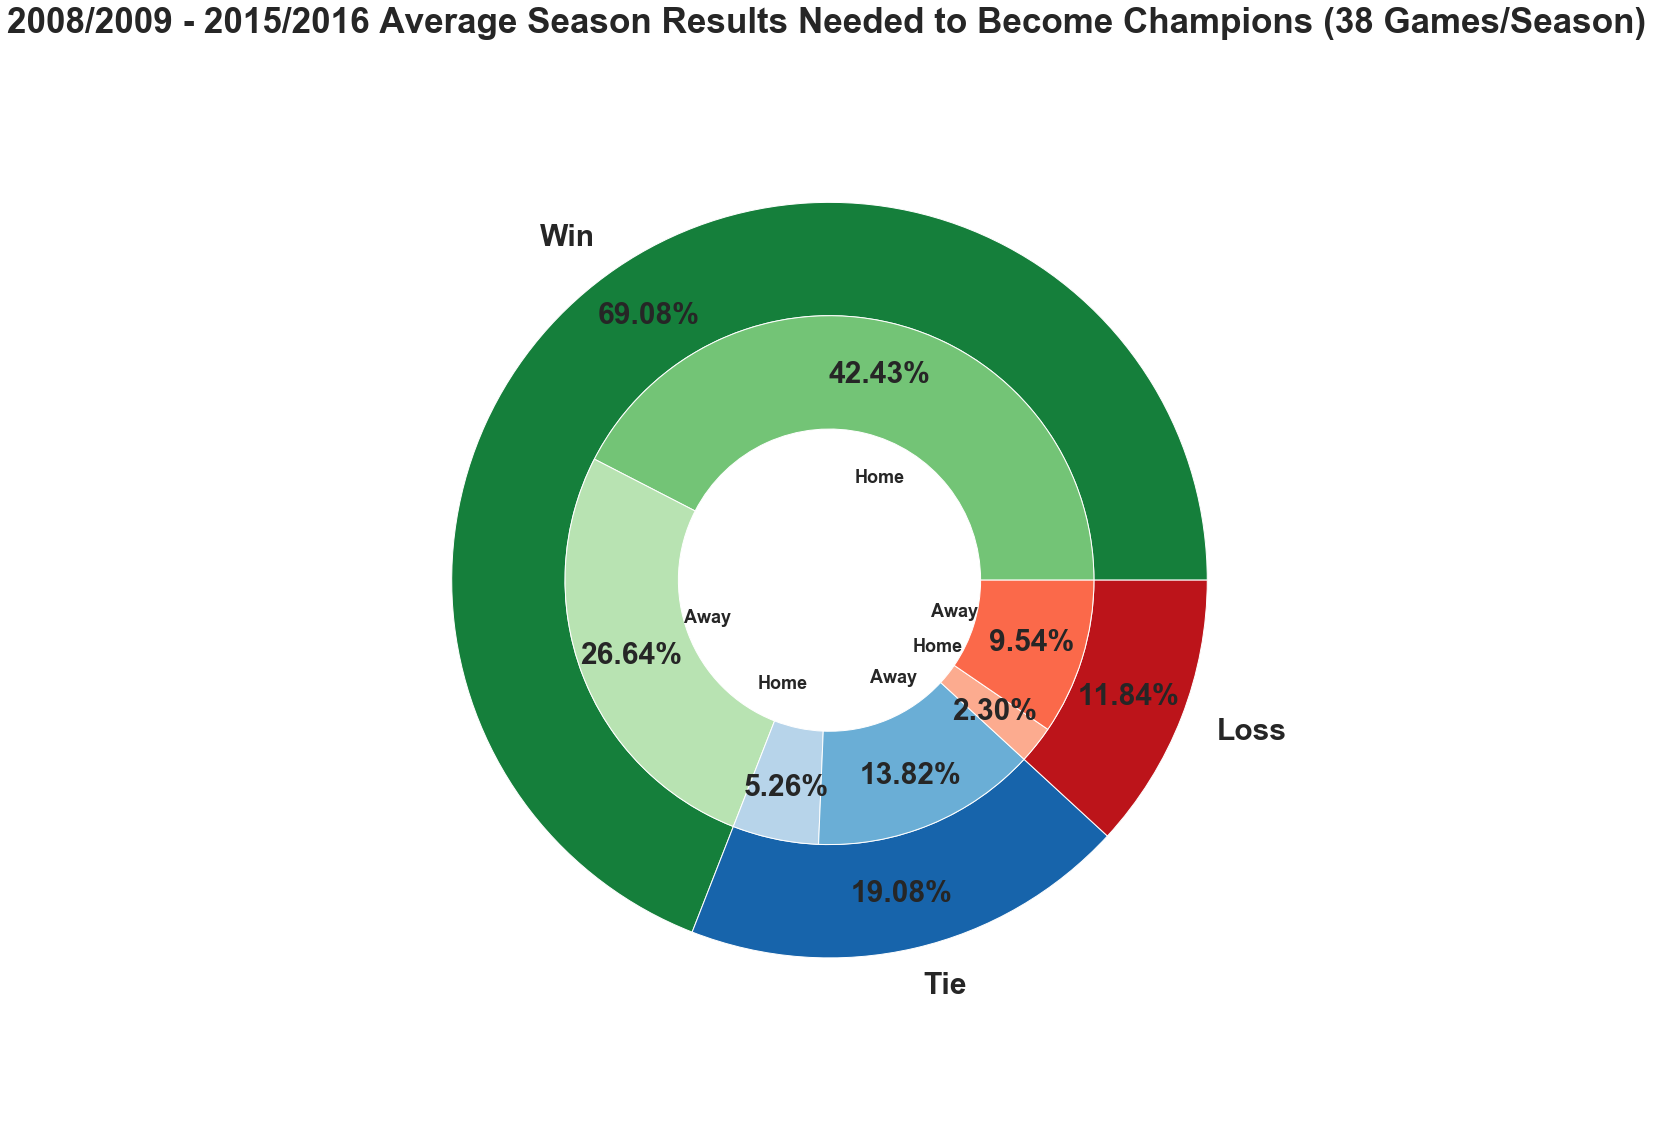

                   league  home_wins  away_wins  home_tie  away_tie  home_loss  away_loss  total_wins  total_tie  total_loss
0  England Premier League     16.125     10.125       2.0      5.25      0.875      3.625       26.25       7.25         4.5


In [234]:
records['total_wins'] = records['home_wins'] + records['away_wins']
records['total_loss'] = records['home_loss'] + records['away_loss']
records['total_tie'] = records['home_tie'] + records['away_tie']
records['league'] = 'England Premier League'
record_summary = records.groupby('league')[['home_wins', 'away_wins', 'home_tie', 'away_tie', 'home_loss', 'away_loss', 'total_wins',
                                'total_tie', 'total_loss']].mean().reset_index()

plt.rcParams['figure.figsize'] = 15, 20

group_names=['Win', 'Tie', 'Loss']
group_size=[record_summary.loc[:, 'total_wins'][0], record_summary.loc[:, 'total_tie'][0], record_summary.loc[:, 'total_loss'][0]]
subgroup_names=['Home', 'Away', 'Home', 'Away', 'Home', 'Away']
subgroup_size=[record_summary.loc[:, 'home_wins'][0], record_summary.loc[:, 'away_wins'][0], record_summary.loc[:, 'home_tie'][0],
              record_summary.loc[:, 'away_tie'][0], record_summary.loc[:, 'home_loss'][0], record_summary.loc[:, 'away_loss'][0]]
 
plt.rcParams["font.size"] = 30


wedges, labels, autopct = plt.pie(group_size, radius=1,
        colors=[a(0.8), b(0.8), c(0.8)],
        labels=group_names, autopct='%.2f%%',
        pctdistance=0.85,
        wedgeprops=dict(width=0.3, edgecolor='white'))

for label in labels:
    label.set_fontsize(30)

wedges, labels, autopct = plt.pie(subgroup_size, radius=0.7,
        colors=[a(0.5), a(0.3), b(0.3), b(0.5), c(.3), c(.5)],
        wedgeprops=dict(width=0.3, edgecolor='white'),
        labels=subgroup_names, autopct='%.2f%%',
        pctdistance=0.8, labeldistance=0.4)
plt.axis('equal')

for label in labels:
    label.set_fontsize(18)

plt.title('2008/2009 - 2015/2016 Average Season Results Needed to Become Champions (38 Games/Season)', fontsize=35, fontweight='bold')
plt.show()
print(record_summary)


**Average Record Needed to Win English League: 26-7-5**

**Average Points Total to Win English League: 86**




# Time of the Season: If We Were to Split the Season into Fall/Winter/Spring, Would We Find Any Noticable Trends Among How the League Performed? 

# Many Say the Winter Part of the Season is the Toughest, Let's See if the Stats Agree

# With 380 Games Total, I'll Split Each Season in the Following Manner;

# Fall - 130 Games
# Winter - 120 Games
# Spring - 130 Games 

In [258]:
dates = pd.read_sql("""SELECT m.date, m.season, l.name AS league, m.home_team_api_id, m.away_team_api_id, m.home_team_goal, m.away_team_goal
                                FROM Match as m
                                INNER JOIN league as l
                                ON m.league_id = l.id
                                WHERE l.name = 'England Premier League'""", conn)

teams = pd.read_sql("""SELECT team_api_id, team_long_name
                        FROM Team""", conn)

for idx, row in dates.iterrows():
    for idx2, row2 in teams.iterrows():
        if row['home_team_api_id'] == row2['team_api_id']:
            dates.loc[idx, 'home_team_api_id'] = row2['team_long_name']
        elif row['away_team_api_id'] == row2['team_api_id']:
            dates.loc[idx, 'away_team_api_id'] = row2['team_long_name']

dates.columns = ['date', 'season', 'league', 'home_team', 'away_team', 'home_team_goal', 'away_team_goal']
print(dates.head(3))
print(len(dates))


                  date     season                  league          home_team             away_team  home_team_goal  away_team_goal
0  2008-08-17 00:00:00  2008/2009  England Premier League  Manchester United      Newcastle United               1               1
1  2008-08-16 00:00:00  2008/2009  England Premier League            Arsenal  West Bromwich Albion               1               0
2  2008-08-16 00:00:00  2008/2009  England Premier League         Sunderland             Liverpool               0               1
3040


In [246]:
print(english_matches.head(3))
print(len(english_matches))

         season                  league          home_team             away_team  home_team_goal  away_team_goal  home_points  away_points
1728  2008/2009  England Premier League  Manchester United      Newcastle United               1               1            1            1
1729  2008/2009  England Premier League            Arsenal  West Bromwich Albion               1               0            3            0
1730  2008/2009  England Premier League         Sunderland             Liverpool               0               1            0            3
3040


In [260]:
match_dates = pd.merge(english_matches, dates, how='inner', on=['season','league', 'home_team', 'away_team','home_team_goal', 'away_team_goal'])
print(match_dates.head(3))
print(len(match_dates))

      season                  league          home_team             away_team  home_team_goal  away_team_goal  home_points  away_points                 date
0  2008/2009  England Premier League  Manchester United      Newcastle United               1               1            1            1  2008-08-17 00:00:00
1  2008/2009  England Premier League            Arsenal  West Bromwich Albion               1               0            3            0  2008-08-16 00:00:00
2  2008/2009  England Premier League         Sunderland             Liverpool               0               1            0            3  2008-08-16 00:00:00
3040


In [272]:
match_dates = match_dates.sort_values('date', ascending=True)
match_dates['total_goals'] = match_dates['home_team_goal'] + match_dates['away_team_goal']

fall = []
winter = []
spring = []

for season in list(match_dates.season.unique()):
    season_df = match_dates.loc[match_dates['season'] == season]
    fall_df = season_df.iloc[:130, :]
    winter_df = season_df.iloc[130:250, :]
    spring_df = season_df.iloc[250:, :]
    print('\n', season + ':', len(season_df))
    print('Fall: ', len(fall_df), 'start: ', min(fall_df.date), 'end: ', max(fall_df.date)) 
    print('Winter: ', len(winter_df), 'start: ', min(winter_df.date), 'end: ', max(winter_df.date)) 
    print('Spring: ', len(spring_df), 'start: ', min(spring_df.date), 'end: ', max(spring_df.date))
    fall.append(fall_df)
    winter.append(winter_df)
    spring.append(spring_df)

fall = pd.concat(fall)
winter = pd.concat(winter)
spring = pd.concat(spring)

print('\n', fall.head(4), '\n', len(fall))


 2008/2009: 380
Fall:  130 start:  2008-08-16 00:00:00 end:  2008-11-22 00:00:00
Winter:  120 start:  2008-11-22 00:00:00 end:  2009-02-21 00:00:00
Spring:  130 start:  2009-02-21 00:00:00 end:  2009-05-24 00:00:00

 2009/2010: 380
Fall:  130 start:  2009-08-15 00:00:00 end:  2009-11-28 00:00:00
Winter:  120 start:  2009-11-28 00:00:00 end:  2010-02-10 00:00:00
Spring:  130 start:  2010-02-10 00:00:00 end:  2010-05-09 00:00:00

 2010/2011: 380
Fall:  130 start:  2010-08-14 00:00:00 end:  2010-11-14 00:00:00
Winter:  120 start:  2010-11-20 00:00:00 end:  2011-02-05 00:00:00
Spring:  130 start:  2011-02-05 00:00:00 end:  2011-05-22 00:00:00

 2011/2012: 380
Fall:  130 start:  2011-08-13 00:00:00 end:  2011-12-03 00:00:00
Winter:  120 start:  2011-12-03 00:00:00 end:  2012-02-12 00:00:00
Spring:  130 start:  2012-02-25 00:00:00 end:  2012-05-13 00:00:00

 2012/2013: 380
Fall:  130 start:  2012-08-18 00:00:00 end:  2012-11-27 00:00:00
Winter:  120 start:  2012-11-27 00:00:00 end:  2013-02

**2008/2009 - 2015/2016 Fall, Winter, & Spring Average Stats Per Game**

  Seasonal_Time  home_team_goal  away_team_goal  total_goals  home_points  away_points
0          Fall        1.569231        1.198077     2.767308     1.597115     1.138462
0        Winter        1.492708        1.138542     2.631250     1.596875     1.118750
0        Spring        1.586538        1.140385     2.726923     1.691346     1.082692


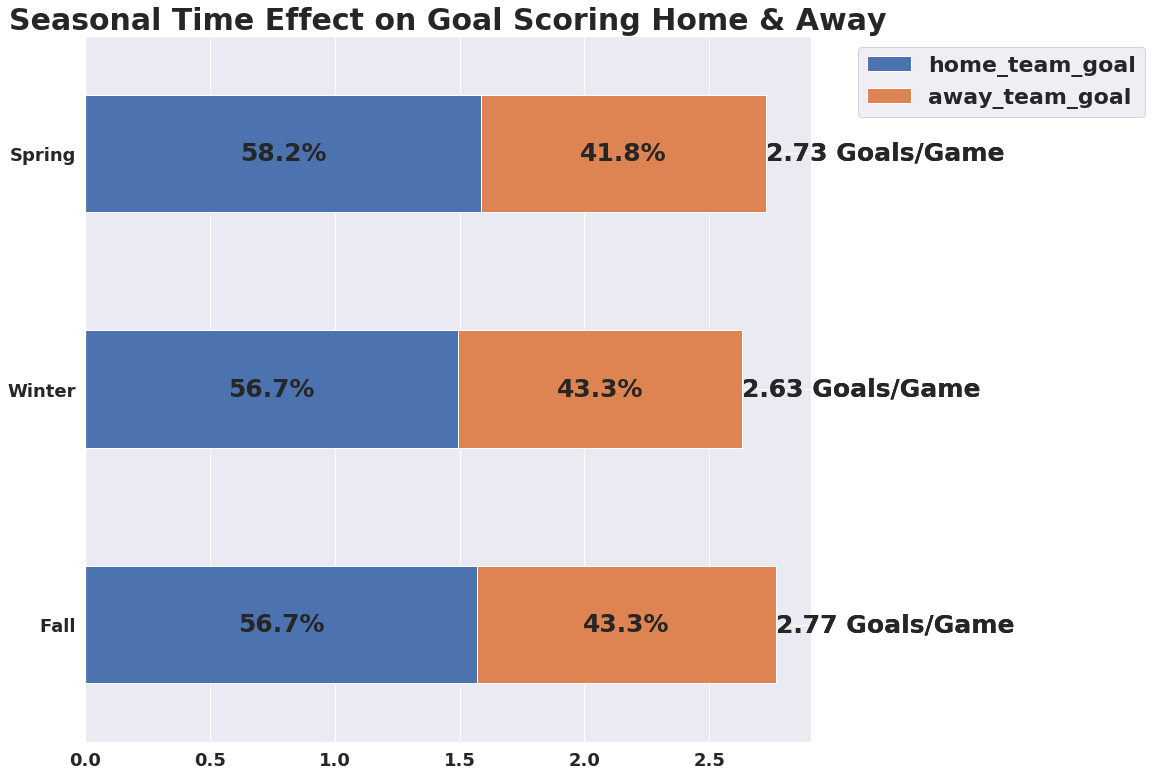

In [338]:
dfs = []
iteration = 0
for df in [fall, winter, spring]:
    iteration += 1
    df = df.groupby('league')[['home_team_goal', 'away_team_goal', 'total_goals', 'home_points', 'away_points']].mean().reset_index()
    if iteration == 1:
        df['Seasonal_Time'] = 'Fall'
    elif iteration == 2:
        df['Seasonal_Time'] = 'Winter'
    else:
        df['Seasonal_Time'] = 'Spring'
    dfs.append(df)
seasonal_df = pd.concat(dfs)
seasonal_df = seasonal_df[['Seasonal_Time', 'home_team_goal', 'away_team_goal', 'total_goals', 'home_points', 'away_points']]
print(seasonal_df)

plt.rcParams['figure.figsize'] = 13, 13
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.family"] = "normal"
plt.rcParams["font.size"] = 25
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
plt.rcParams['axes.labelsize']=18
plt.rcParams['legend.fontsize']: 27


# seasonal_df = seasonal_df[['Seasonal_Time', 'home_team_goal', 'away_team_goal' ]]
# seasonal_df.plot(x='Seasonal_Time', kind='bar', stacked=True, mark_right=True)
# plt.title('Seasonal Time Effect on Goal Scoring Home & Away', fontweight='bold')
# plt.ylabel('Goals/Game')
# plt.xticks(rotation=45)
# plt.legend(fontsize=15, loc='upper center')
# plt.show()

df_total = seasonal_df['total_goals']
df = seasonal_df.iloc[:, :3]
df.plot(x = 'Seasonal_Time', kind='barh',stacked = True, mark_right = True)

df_rel = df[df.columns[1:]].div(df_total, 0)*100

for n in df_rel:
    for i, (cs, ab, pc, tot) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], df[n], df_rel[n], df_total)):
        plt.text(tot, i, str(round(tot, 2)) + ' Goals/Game', va='center')
        plt.text(cs - ab/2, i, str(np.round(pc, 1)) + '%', va='center', ha='center')

plt.title('Seasonal Time Effect on Goal Scoring Home & Away', fontsize=30,fontweight='bold')
plt.ylabel('')
# plt.xlabel('Goals/Game')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=22)


# Summary: 

# - Most Goals/Game at the Start of Each Season (Teams Adapting to New Players/Coaches/Style Leading to More Vulnerability on Defense?)
# - Winter Was Indeed the Period of the Season in Which Teams Stuggle the Most to Score Goals Home or Away 
# - At the End of Each Season Teams Appear to Become Strongest at Home, Resulting in a worse away form compared to the start of the season (but still better than winter form)